In [3]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage.measure import label

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.lib import utils
from src.lib import centroids as centutils
from src.lib import cell_blobs_skimage as blobsutils

In [4]:
def draw_centroids(img, centroids):
    centroids_img = img.copy()
    for centroid in centroids:
        cv2.circle(centroids_img, tuple(centroid), 5, (0, 255, 0), -1)
    return centroids_img

In [5]:
imgs_dir_ctnna = '../data/raw/ctnna-b/images'
img_name_ctnna = 'CTNNA1_A3_NS'
imgs_dir_negsi = '../data/raw/images'
img_name_negsi = 'NegsiRNA_A1_NO'
nuclei_img_ctnna, _, seg_img_ctnna, _ = utils.load_images(
                                imgs_dir_ctnna, img_name_ctnna)
nuclei_img_negsi, _, seg_img_negsi, _ = utils.load_images(
                                imgs_dir_negsi, img_name_negsi)

nuclei_img_negsi = utils.convert_16_gray_to_8_bgr(nuclei_img_negsi)
nuclei_img_ctnna = utils.convert_16_gray_to_8_bgr(nuclei_img_ctnna)

In [11]:
centroids_negsi = centutils.remove_close_centroids(centutils.get_nuclei_centroids(nuclei_img_negsi), radio=50)
centroids_ctnna = centutils.remove_close_centroids(centutils.get_nuclei_centroids(nuclei_img_ctnna), radio=50)

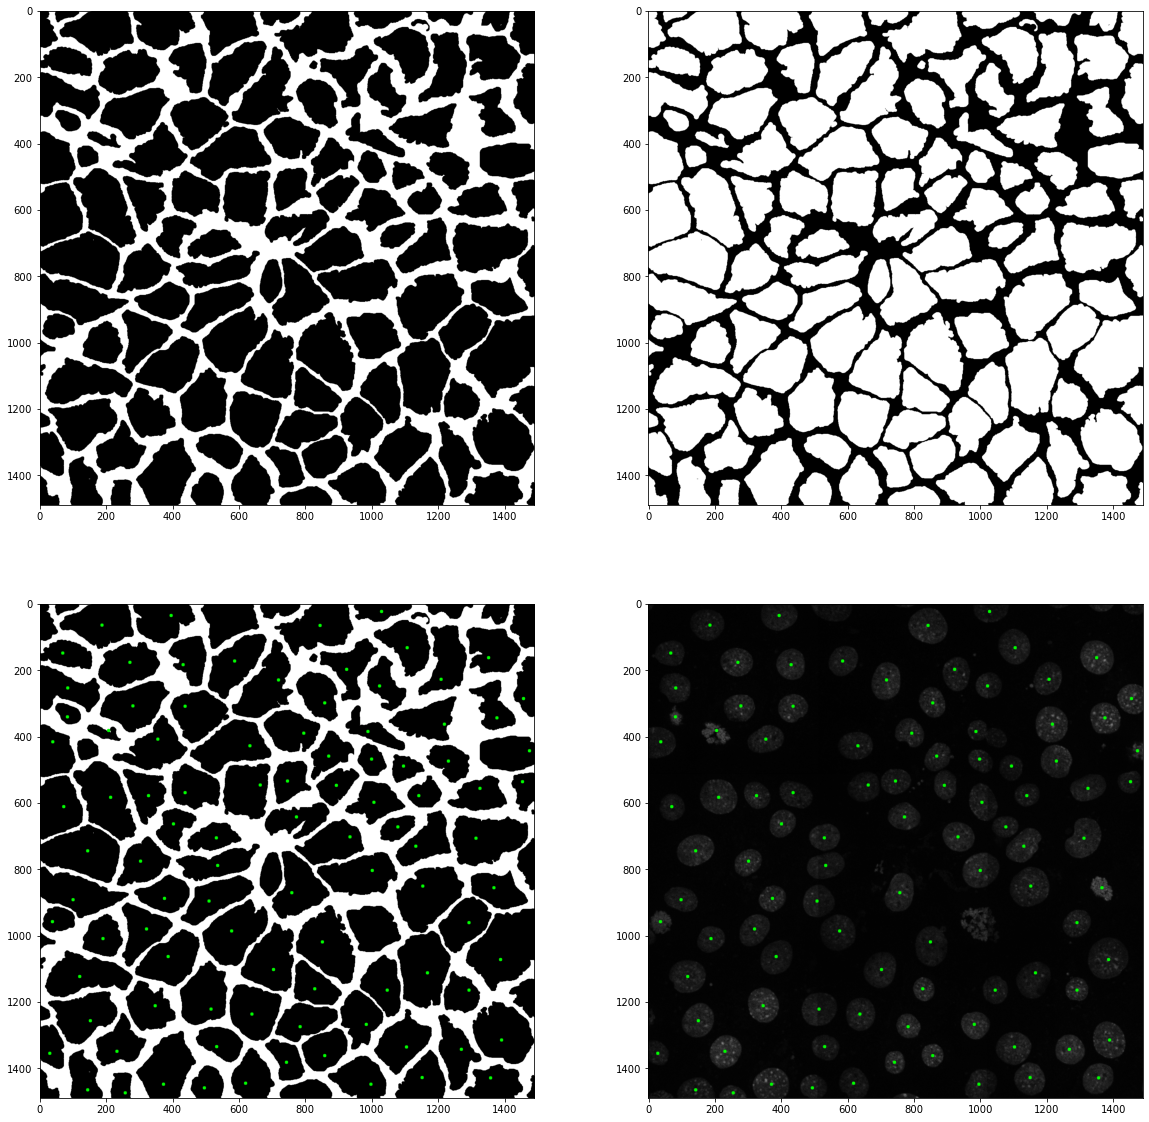

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

ax[0, 0].imshow(seg_img_negsi, cmap='gray')
ax[0, 1].imshow(invert(seg_img_negsi), cmap='gray')
ax[1, 0].imshow(draw_centroids(cv2.cvtColor(seg_img_negsi, cv2.COLOR_GRAY2BGR), centroids_negsi), cmap='gray')
ax[1, 1].imshow(draw_centroids(nuclei_img_negsi, centroids_negsi))


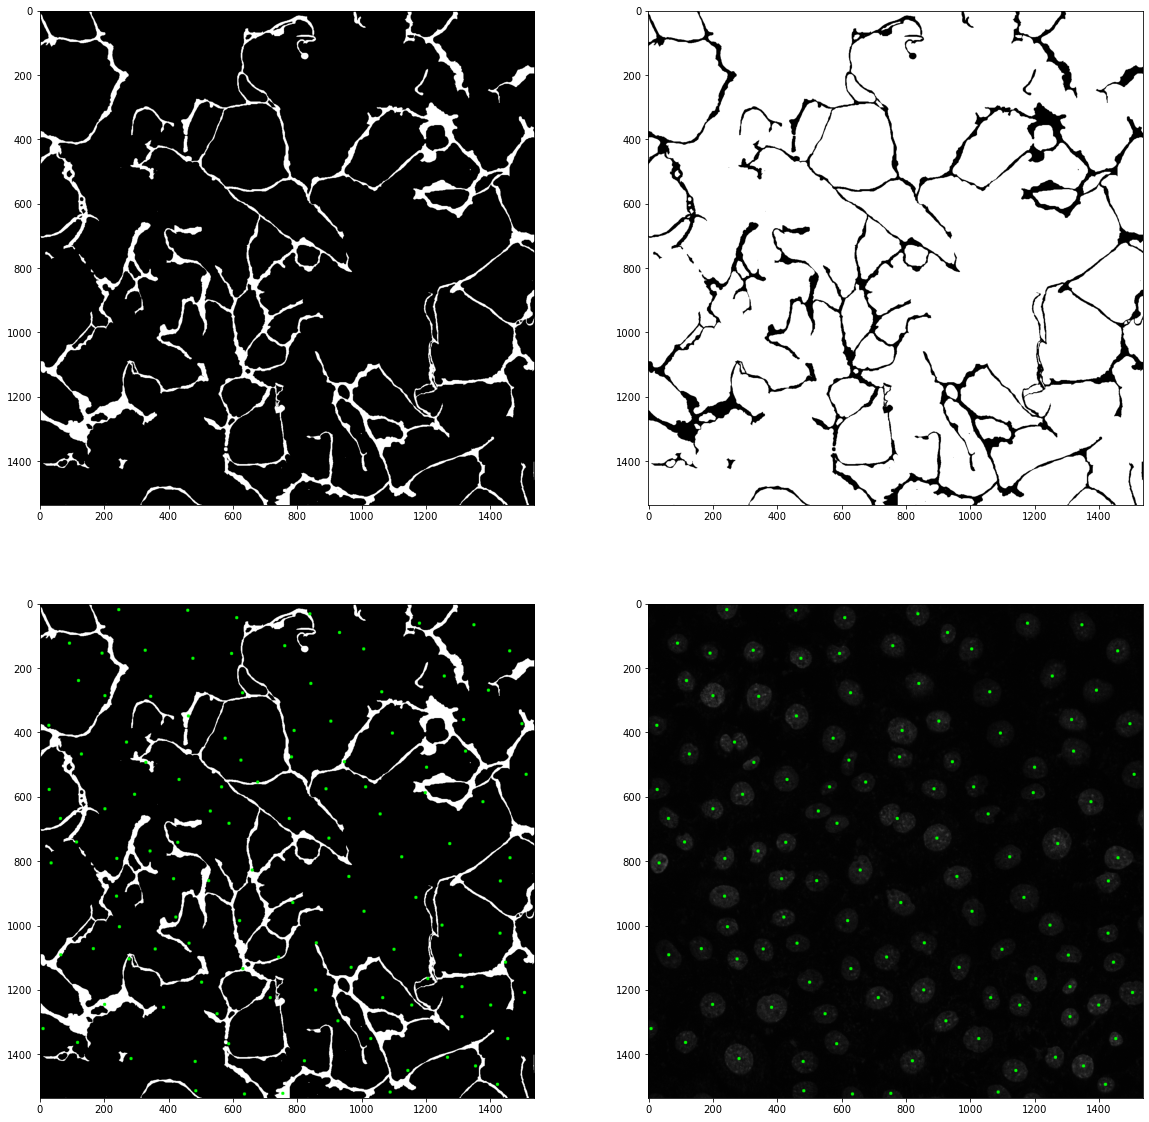

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

ax[0, 0].imshow(seg_img_ctnna, cmap='gray')
ax[0, 1].imshow(invert(seg_img_ctnna), cmap='gray')
ax[1, 0].imshow(draw_centroids(cv2.cvtColor(seg_img_ctnna, cv2.COLOR_GRAY2BGR), centroids_ctnna), cmap='gray')
ax[1, 1].imshow(draw_centroids(nuclei_img_ctnna, centroids_ctnna))

In [31]:
df_props_negsi, label_img_negsi = blobsutils.get_blobs_measurements(seg_img_negsi, remove_borders=True, return_img=True)

label_img_negsi_small = label_img_negsi.copy()
label_img_negsi_keep = label_img_negsi.copy() 

label_img_negsi_small[np.isin(
    label_img_negsi, df_props_negsi['label'])] = 0 
label_img_negsi_keep[~np.isin(
    label_img_negsi, df_props_negsi['label'])] = 0

label_border_negsi = label(invert(seg_img_negsi))

Text(0.5, 1.0, 'Useful blobs')

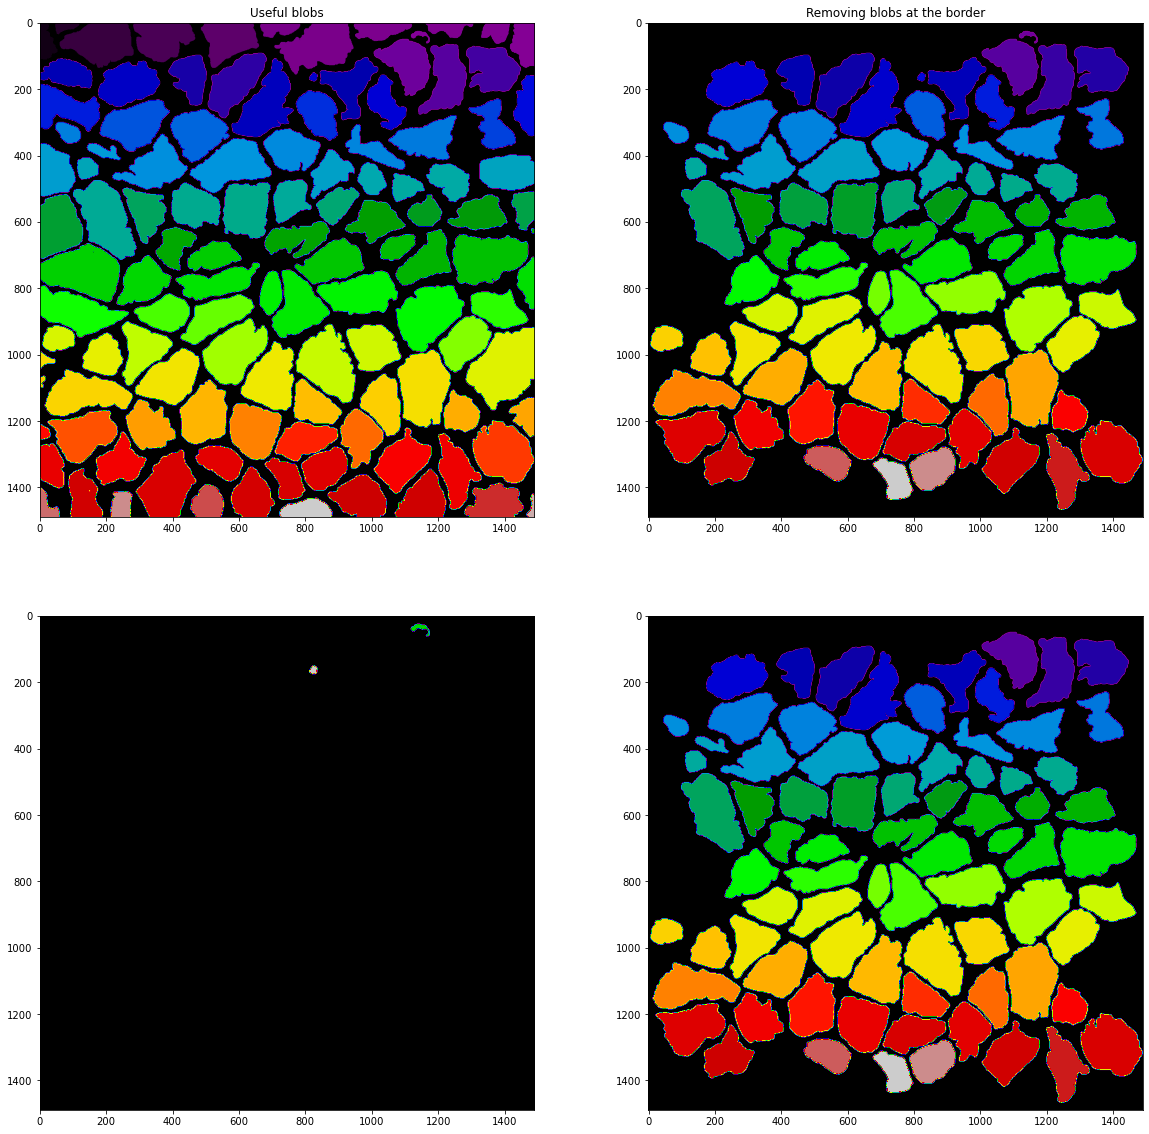

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(label_border_negsi, cmap='nipy_spectral')
ax[0, 0].set_title('All blobs')

ax[0, 1].imshow(label_img_negsi, cmap='nipy_spectral')
ax[0, 1].set_title('Removing blobs at the border')

ax[1, 0].imshow(label_img_negsi_small, cmap='nipy_spectral')
ax[0, 0].set_title('Blobs too small (area < 900)')

ax[1, 1].imshow(label_img_negsi_keep, cmap='nipy_spectral')
ax[0, 0].set_title('Useful blobs')

In [33]:
df_props_ctnna, label_img_ctnna = blobsutils.get_blobs_measurements(seg_img_ctnna, remove_borders=True, return_img=True)

label_img_ctnna_small = label_img_ctnna.copy()
label_img_ctnna_keep = label_img_ctnna.copy() 

label_img_ctnna_small[np.isin(
    label_img_ctnna, df_props_ctnna['label'])] = 0 
label_img_ctnna_keep[~np.isin(
    label_img_ctnna, df_props_ctnna['label'])] = 0

label_border_ctnna = label(invert(seg_img_ctnna))

Text(0.5, 1.0, 'Useful blobs')

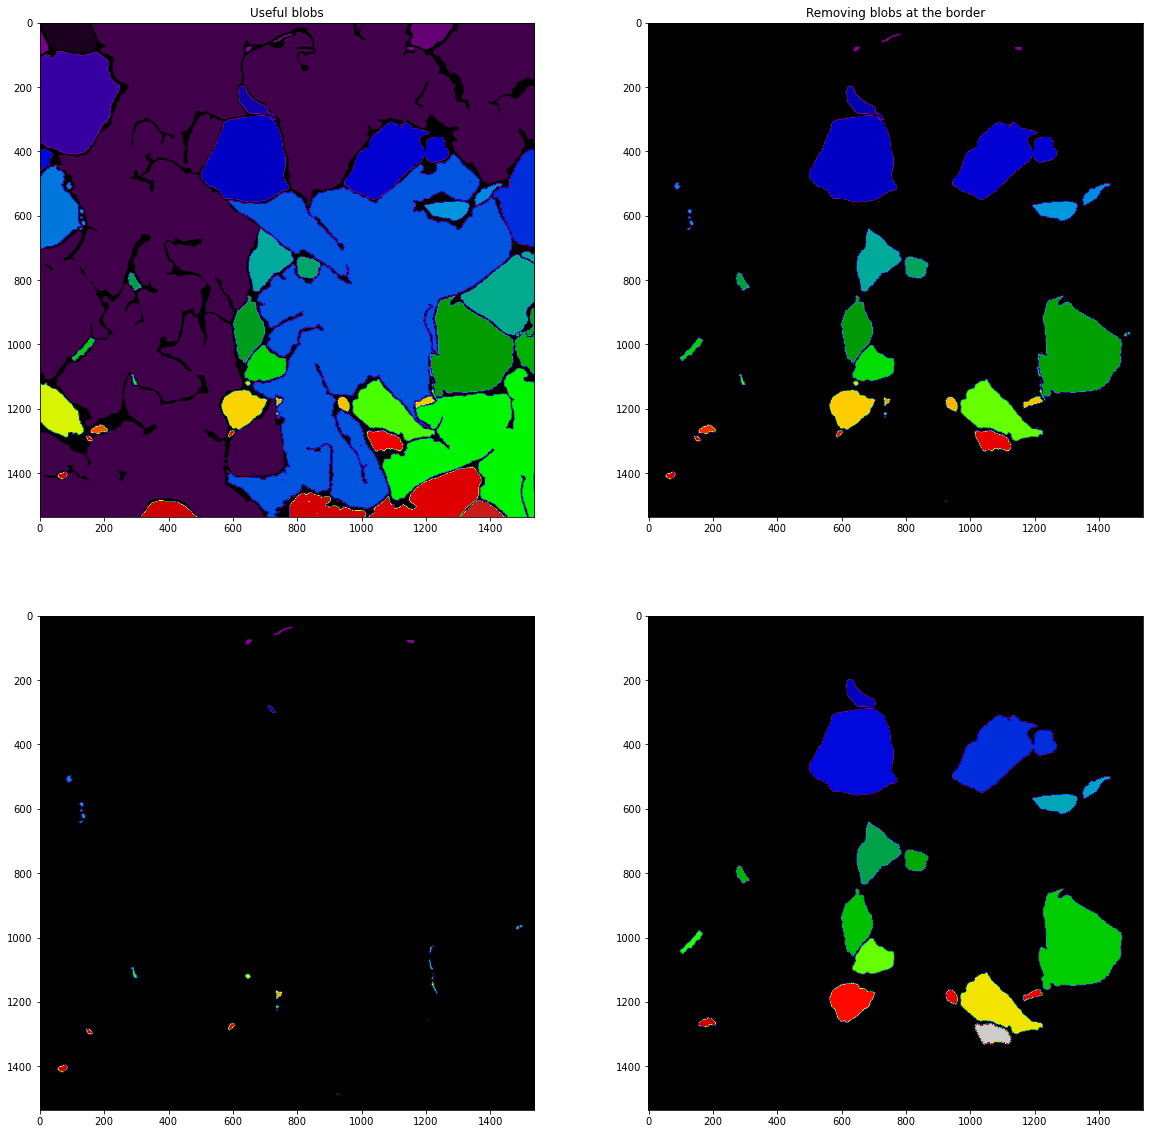

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(label_border_ctnna, cmap='nipy_spectral')
ax[0, 0].set_title('All blobs')

ax[0, 1].imshow(label_img_ctnna, cmap='nipy_spectral')
ax[0, 1].set_title('Removing blobs at the border')

ax[1, 0].imshow(label_img_ctnna_small, cmap='nipy_spectral')
ax[0, 0].set_title('Blobs too small (area < 900)')

ax[1, 1].imshow(label_img_ctnna_keep, cmap='nipy_spectral')
ax[0, 0].set_title('Useful blobs')

In [14]:
df_props_ctnna_borders, label_img_ctnna_borders = blobsutils.get_blobs_measurements(seg_img_ctnna, remove_borders=False, return_img=True)
len(df_props_ctnna_borders), len(centroids_ctnna)

(36, 120)

In [15]:
df_props_negsi_borders, label_img_negsi_borders = blobsutils.get_blobs_measurements(seg_img_negsi, remove_borders=False, return_img=True)
len(df_props_negsi_borders), len(centroids_negsi)

(114, 97)

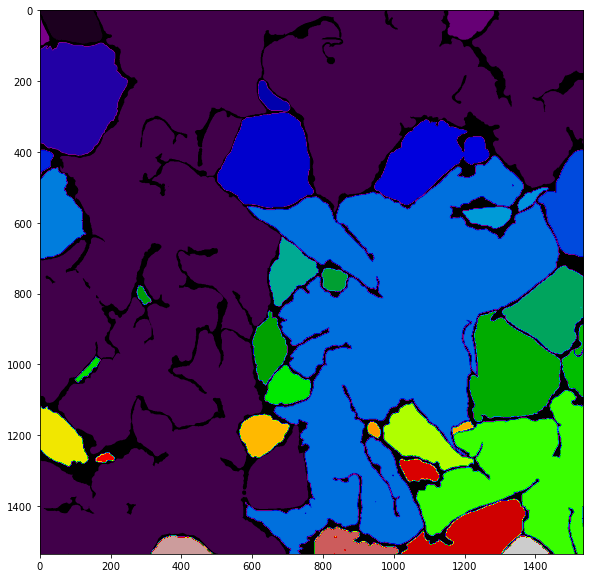

In [23]:
plt.figure(figsize=(10, 10))
label_img_ctnna_borders_keep = label_img_ctnna_borders.copy()
label_img_ctnna_borders_keep[~np.isin(
    label_img_ctnna_borders, df_props_ctnna_borders['label'])] = 0
plt.imshow(label_img_ctnna_borders_keep, cmap='nipy_spectral')

In [31]:
df_props_negsi['convexity'].median()

0.9244676588052856

In [37]:
def get_contours_and_moments(seg_img, min_area=900):
    seg_inv = invert(seg_img)
    label_img = label(seg_inv)
    borders = np.array([label_img[0], 
                        label_img[-1], 
                        label_img[:, 0], 
                        label_img[:, -1]])
    blobs_at_borders = np.unique(borders)

    label_img_no_borders = label_img.copy()
    label_img_no_borders[np.isin(label_img, blobs_at_borders)] = 0
    props = regionprops_table(label_img_no_borders, 
                              intensity_image=seg_inv,
                              properties=('label', 'centroid', 
                                          'area', 'perimeter',
                                          'convex_area', 'solidity',
                                          'major_axis_length',
                                          'minor_axis_length',
                                          'convex_image'))
    df_props = pd.DataFrame(props)
    df_props['convex_perimeter'] = df_props['convex_image'].apply(lambda img: perimeter(img))
    df_props['compactness'] = 4 * np.pi * df_props['area'] / (df_props['perimeter'] ** 2)
    df_props['convexity'] = df_props['convex_perimeter'] / df_props['perimeter']
    df_props['elongation'] = df_props['major_axis_length'] / df_props['minor_axis_length']

    return label_img_no_borders, df_props

In [38]:
label_img, df_props = get_contours_and_moments(seg_img)

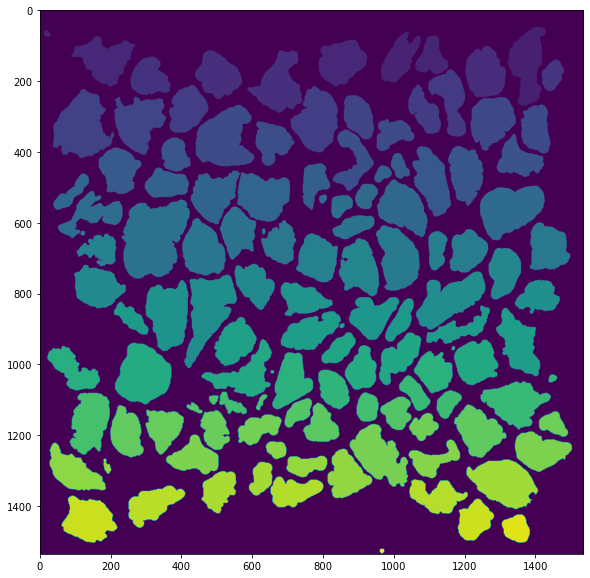

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(label_img)

In [40]:
scale = 0.14 # um / pixels
size_nucleus_um = 5 
size_nucleus_pixels = size_nucleus_um / scale
size_nucleus_pixels

35.71428571428571

In [41]:
keep = df_props.loc[df_props['area'] >= 900, 'label'].values
small = df_props.loc[df_props['area'] < 900, 'label'].values

In [56]:
df_props[df_props['area'] >= 900]

label  centroid-0  centroid-1   area   perimeter  convex_area  solidity  \
0       15         152        1376  14722  625.671140        17604  0.836287   
2       17         136        1014   8896  462.114790         9840  0.904065   
3       18         133        1105   6197  352.291414         7032  0.881257   
4       19         139         182  13734  592.742207        16541  0.830300   
5       20         146         850  12661  455.931024        13313  0.951025   
..     ...         ...         ...    ...         ...          ...       ...   
118    152        1373        1119   9558  524.457936        11790  0.810687   
119    153        1394         317  10675  491.587878        11839  0.901681   
120    157        1439         136  13829  522.943218        15262  0.906107   
121    158        1440        1226   8016  370.575685         8640  0.927778   
123    163        1464        1345   4692  265.965512         4845  0.968421   

     major_axis_length  minor_axis_length  \
0           229.717705          93.076989   
2           157.436749          75.594089   
3           110.277188          83.188097   
4           159.504534         126.210001   
5           142.226355         115.760829   
..                 ...                ...   
118         161.153634          88.547544   
119         173.570381          83.584614   
120         148.155066         123.238923   
121         118.033894          88.578651   
123          83.439762          73.340235   

                                          convex_image  convex_perimeter  \
0    [[False, False, False, False, False, False, Fa...        570.818326   
2    [[False, False, False, False, False, False, Fa...        413.102597   
3    [[False, False, False, False, False, False, Fa...        337.320851   
4    [[False, False, False, False, False, False, Fa...        517.327994   
5    [[False, False, False, False, False, False, Fa...        438.859956   
..                                                 ...               ...   
118  [[False, False, False, False, False, False, Fa...        434.717821   
119  [[False, False, False, False, False, False, Fa...        451.487373   
120  [[False, False, False, False, False, False, Fa...        479.931024   
121  [[False, False, False, False, False, False, Fa...        352.818326   
123  [[False, False, False, False, False, False, Fa...        265.965512   

     compactness  convexity  elongation  
0       0.472590   0.912330    2.468040  
2       0.523486   0.893939    2.082660  
3       0.627462   0.957505    1.325637  
4       0.491219   0.872771    1.263803  
5       0.765384   0.962558    1.228622  
..           ...        ...         ...  
118     0.436672   0.828890    1.819967  
119     0.555105   0.918427    2.076583  
120     0.635465   0.917750    1.202178  
121     0.733523   0.952082    1.332532  
123     0.833522   1.000000    1.137708  

[110 rows x 14 columns]

In [42]:
keep, small

(array([ 15,  17,  18,  19,  20,  22,  23,  24,  25,  26,  29,  30,  31,
         32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  44,  45,  46,
         47,  48,  49,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         63,  64,  65,  66,  67,  68,  69,  70,  72,  74,  75,  76,  78,
         79,  81,  82,  84,  85,  86,  87,  89,  90,  91,  93,  94,  95,
         96,  97, 101, 102, 103, 104, 105, 106, 107, 109, 110, 112, 115,
        116, 118, 119, 120, 121, 125, 126, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149,
        151, 152, 153, 157, 158, 163]),
 array([ 16,  43,  62,  71,  73, 100, 108, 113, 114, 122, 123, 127, 146,
        159, 171]))

In [43]:
len(keep) + len(small)

125

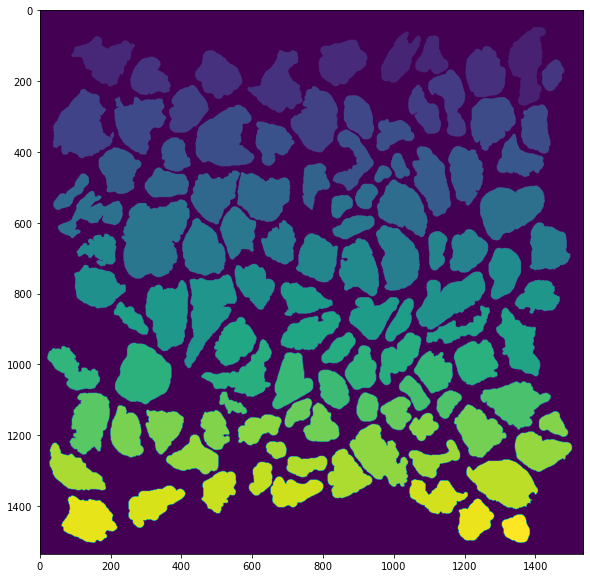

In [44]:
keep_img = label_img.copy()
keep_img[~np.isin(label_img, keep)] = 0
plt.figure(figsize=(10, 10))
plt.imshow(keep_img)

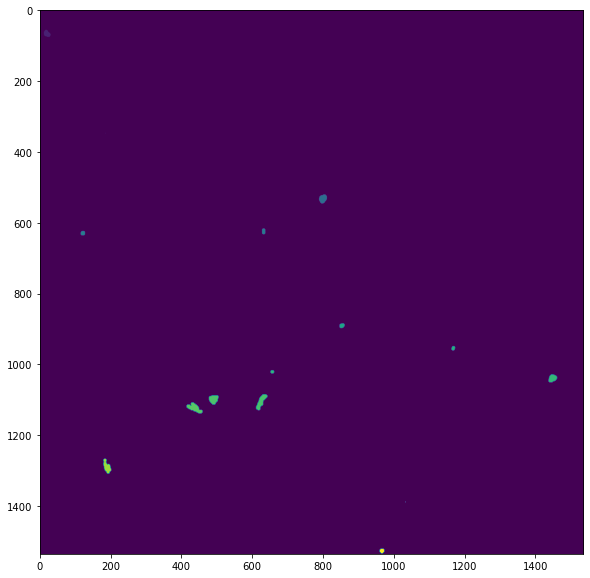

In [45]:
remove_img = label_img.copy()
remove_img[np.isin(label_img, keep)] = 0
plt.figure(figsize=(10, 10))
plt.imshow(remove_img)

In [46]:
df_props['centroid-0'] = df_props['centroid-0'].astype(int)
df_props['centroid-1'] = df_props['centroid-1'].astype(int)

In [51]:
df_props.drop(columns="convex_image").rename(columns=
    {'convex_area': 'hull_area',
     'convex_perimeter': 'hull_perimeter'}) 

label  centroid-0  centroid-1   area   perimeter  hull_area  solidity  \
0       15         152        1376  14722  625.671140      17604  0.836287   
1       16          66          19    275   61.698485        284  0.968310   
2       17         136        1014   8896  462.114790       9840  0.904065   
3       18         133        1105   6197  352.291414       7032  0.881257   
4       19         139         182  13734  592.742207      16541  0.830300   
..     ...         ...         ...    ...         ...        ...       ...   
120    157        1439         136  13829  522.943218      15262  0.906107   
121    158        1440        1226   8016  370.575685       8640  0.927778   
122    159        1388        1031      2    0.000000          2  1.000000   
123    163        1464        1345   4692  265.965512       4845  0.968421   
124    171        1526         965    140   40.384776        140  1.000000   

     major_axis_length  minor_axis_length  hull_perimeter  compactness  \
0           229.717705          93.076989      570.818326     0.472590   
1            22.452294          16.007679       61.112698     0.907807   
2           157.436749          75.594089      413.102597     0.523486   
3           110.277188          83.188097      337.320851     0.627462   
4           159.504534         126.210001      517.327994     0.491219   
..                 ...                ...             ...          ...   
120         148.155066         123.238923      479.931024     0.635465   
121         118.033894          88.578651      352.818326     0.733523   
122           2.828427           0.000000        0.000000          inf   
123          83.439762          73.340235      265.965512     0.833522   
124          13.661098          13.079277       40.384776     1.078705   

     convexity  elongation  
0     0.912330    2.468040  
1     0.990506    1.402595  
2     0.893939    2.082660  
3     0.957505    1.325637  
4     0.872771    1.263803  
..         ...         ...  
120   0.917750    1.202178  
121   0.952082    1.332532  
122        NaN         inf  
123   1.000000    1.137708  
124   1.000000    1.044484  

[125 rows x 13 columns]

In [70]:
def map_dfs(df_props, df_prev):
    map_dict = {}
    for index, row in df_props.iterrows():
        y, x = row['centroid-0'], row['centroid-1']
        coincidences = df_prev[(abs(df_prev['x'] - x) <= 1) & \
                            (abs(df_prev['y'] - y) <= 1)]
        map_dict[index] = coincidences.index[0]
    return map_dict

In [71]:
map_dict = map_dfs(df_props, df_prev)

In [72]:
map_dict

{0: 227,
 1: 226,
 2: 225,
 3: 224,
 4: 223,
 5: 222,
 6: 221,
 7: 220,
 8: 219,
 9: 218,
 10: 217,
 11: 216,
 12: 215,
 13: 214,
 14: 213,
 15: 212,
 16: 211,
 17: 210,
 18: 209,
 19: 208,
 20: 207,
 21: 206,
 22: 205,
 23: 204,
 24: 203,
 25: 202,
 26: 201,
 27: 200,
 28: 199,
 29: 198,
 30: 197,
 31: 196,
 32: 195,
 33: 194,
 34: 193,
 35: 192,
 36: 191,
 37: 190,
 38: 189,
 39: 188,
 40: 187,
 41: 186,
 42: 185,
 43: 184,
 44: 183,
 45: 182,
 46: 181,
 47: 180,
 48: 179,
 49: 178,
 50: 177,
 51: 176,
 52: 175,
 53: 174,
 54: 173,
 55: 172,
 56: 171,
 57: 170,
 58: 169,
 59: 168,
 60: 167,
 61: 166,
 62: 165,
 63: 164,
 64: 163,
 65: 162,
 66: 161,
 67: 160,
 68: 159,
 69: 158,
 70: 157,
 71: 156,
 72: 155,
 73: 154,
 74: 153,
 75: 152,
 76: 151,
 77: 150,
 78: 149,
 79: 148,
 80: 147,
 81: 146,
 82: 145,
 83: 144,
 84: 143,
 85: 142,
 86: 141,
 87: 140,
 88: 139,
 89: 138,
 90: 137,
 91: 136,
 92: 135,
 93: 134,
 94: 133,
 95: 132,
 96: 131,
 97: 130,
 98: 129,
 99: 128,
 100: 127,

In [92]:
df_props['new_index'] = map_dict.values()
df_props = df_props.set_index('new_index')

In [102]:
x = df_props['compactness'] / df_prev['compactness']
x.sort_values()

94     0.973080
126    0.975184
176    0.977554
131    0.993672
86     0.994039
         ...   
122    1.044359
8      1.064642
211         inf
84          inf
67          NaN
Name: compactness, Length: 228, dtype: float64

In [104]:
df_prev.loc[84]

x                    1.068000e+03
y                    7.990000e+02
m00                  2.000000e+00
m10                  2.136000e+03
m01                  1.598000e+03
m20                  2.281248e+06
m11                  1.706664e+06
m02                  1.276802e+06
m30                  2.436374e+09
m21                  1.822717e+09
m12                  1.363625e+09
m03                  1.020166e+09
mu20                 3.333333e-01
mu11                 0.000000e+00
mu02                 3.333333e-01
mu30                 9.536743e-07
mu21                 1.685694e-07
mu12                 8.288771e-08
mu03                 2.384186e-07
nu20                 8.333333e-02
nu11                 0.000000e+00
nu02                 8.333333e-02
nu30                 1.685874e-07
nu21                 2.979914e-08
nu12                 1.465262e-08
nu03                 4.214685e-08
area                 2.000000e+00
perimeter            5.656854e+00
hull_area            2.000000e+00
hull_perimeter